### Parameter setting

In [1]:
%matplotlib inline
from analysis_utils import display_wrapper, image2stack, plot_onset_index, rotate_crop_array
# from analysis_utils import cal_velocity
from inout_utils import h5py_write
from glob import glob
from os.path import join as pjoin
from pprint import pprint
from scipy.ndimage import rotate
from skimage import measure
from tifffile import imread, imwrite, TiffFile
from tqdm import tqdm
from wf_utils import filename2int, log_progress
from wfield.io import frames_average_for_trials, mmap_dat, TiffStack
from wfield import approximate_svd

import cv2, os, shutil, subprocess, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plot_test = True
# Set the file path
root_path = '/home/wrx/Data_WF/WF_WRX/'
# mice_id = 'Q38'
# treat = '20240826_DOM'

mice_id = 'Q39'
treat = '20240829_saline'

path_0 = pjoin(root_path, mice_id, treat)
# path_0 = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/24.07.18_P73'
print(path_0)

path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n')
pprint(path_all)
path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
pprint(path_wfield_all)

# The abbreviation of the different stimuli
abbrev_dict = {'Looming': 'LM',
    'MovingBar': 'MB',
    'NatureMovie': 'NM',
    'Retinotopy': 'RT', 
    'SalienceGrating': 'SG', 
    'SalienceMovingGrating': 'SMG', 
    'Spontaneous': 'ST', }

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline
All the file path:

['/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/1_Spontaneous',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/3_Movingbar',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/4_SalienceGrating',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/5_SalienceMovingGrating',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/6_Looming',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/7_NatureMovie']
['/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/1_Spontaneous/process/20240829-160641-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/3_Movingbar/process/20240829-165104-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/4_SalienceGrating/process/20240829-165723-wfield',
 '/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/5_SalienceMovingGrating/process/20240829-170313-wfield',
 '/hom

### Re-organize files

In [ ]:
# only run this cell once
for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


### Crop, rotate and mask the raw images

Note: rotate the images is time-consuming, skip rotate the images by setting angle=0

In [71]:
def show_images(images, vlim=None, title=None, idential_colorbar=False):
    '''
    images: list
    '''
    nrows = 1
    ncols = len(images)

    if vlim is None:
        vmin = np.array([image.min() for image in images]).min()
        vmax = np.array([image.max() for image in images]).max()

    fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 7*nrows))
    for i, ax in enumerate(axes):
        if idential_colorbar:
            cb = ax.imshow(images[i], cmap='hot', clim=(0, vmax))
        else:
            cb = ax.imshow(images[i], cmap='hot')
        ax.grid()
        
    if title is not None:
        for i, ax in enumerate(axes):
            ax.set_title(title[i])    
    if idential_colorbar:
        fig.colorbar(cb, ax=axes, orientation='vertical', fraction=0.05, shrink=0.5)

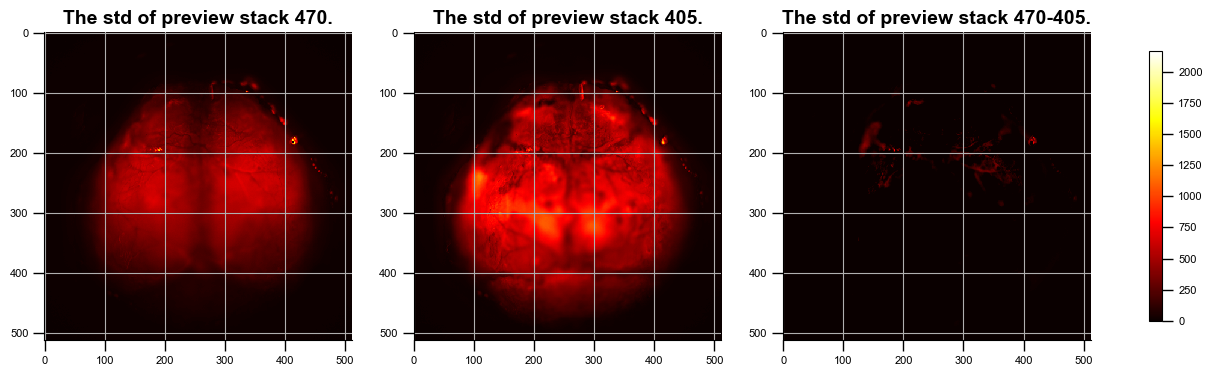

In [46]:
n_preview = 600
tiff_list_470 = glob(pjoin(path_all[0], 'raw/*-470/*.tif'))[:n_preview]
preview_stack_470 = np.array([imread(tiff) for tiff in tiff_list_470])
tiff_list_405 = glob(pjoin(path_all[0], 'raw/*-405/*.tif'))[:n_preview]
preview_stack_405 = np.array([imread(tiff) for tiff in tiff_list_405])
preview_std_470 = np.std(preview_stack_470, axis=0)
preview_std_405 = np.std(preview_stack_405, axis=0)

if plot_test:
    images = [preview_std_470, preview_std_405, preview_std_470 - preview_std_405]
    title = ['The std of preview stack 470.', 
            'The std of preview stack 405.', 
            'The std of preview stack 470-405.']
    show_images(images, title=title, idential_colorbar=True)

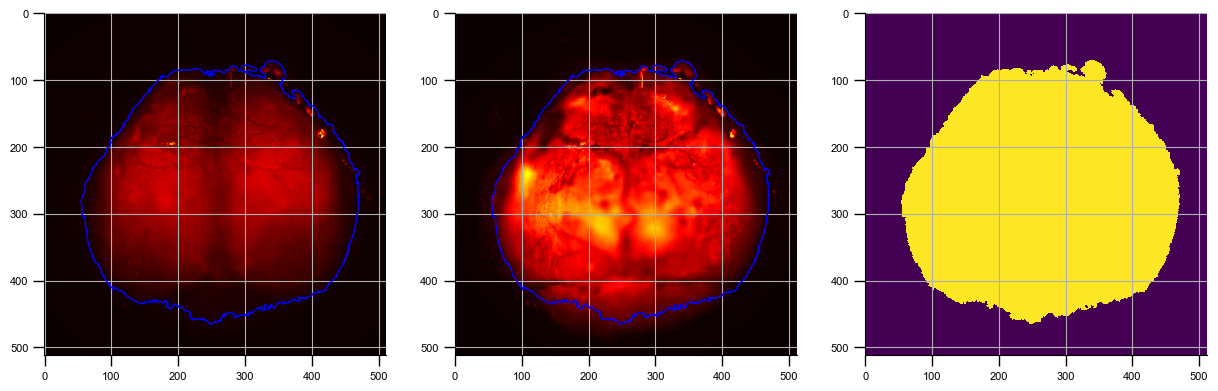

In [54]:
std_level = 50
contour = measure.find_contours(image=preview_std_470, level=std_level)
contour_len = [len(_contour) for _contour in contour]
contour_max = contour[np.argmax(contour_len)]

mask = np.zeros_like(preview_std_470)
mask_edge = np.flip(contour_max, axis=1).astype(int)
mask = cv2.fillPoly(mask, [mask_edge], 1)

if plot_test:
    fig, axis = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
    
    axis[0].imshow(preview_std_470, cmap='hot')
    axis[0].plot(contour_max[:, 1], contour_max[:, 0], linewidth=1, color='blue')
    axis[0].grid()
    axis[1].imshow(preview_std_405, cmap='hot')
    axis[1].plot(contour_max[:, 1], contour_max[:, 0], linewidth=1, color='blue')
    axis[1].grid()
    axis[2].imshow(mask)
    axis[2].grid()
    plt.show()

Read the parameters from the results.hdf5 file if it exists, otherwise use the default parameters.

In [6]:
result_path = pjoin(path_0, 'results.hdf5')
if os.path.exists(result_path):
    print('The result file already exists, read parameters from it.')
    from inout_utils import h5py_read
    result = h5py_read(result_path)

if 'params' in result.keys():
    params = result['params']
    # angle = params['angle']
    angle = 0
    left, top, width, height = params['crop']
    mask = params['mask']
else:
    angle = 0 # if clockwise, use negative angle, otherwise positive
    left, top, width, height = 50, 80, 450, 380

The result file already exists, read parameters from it.


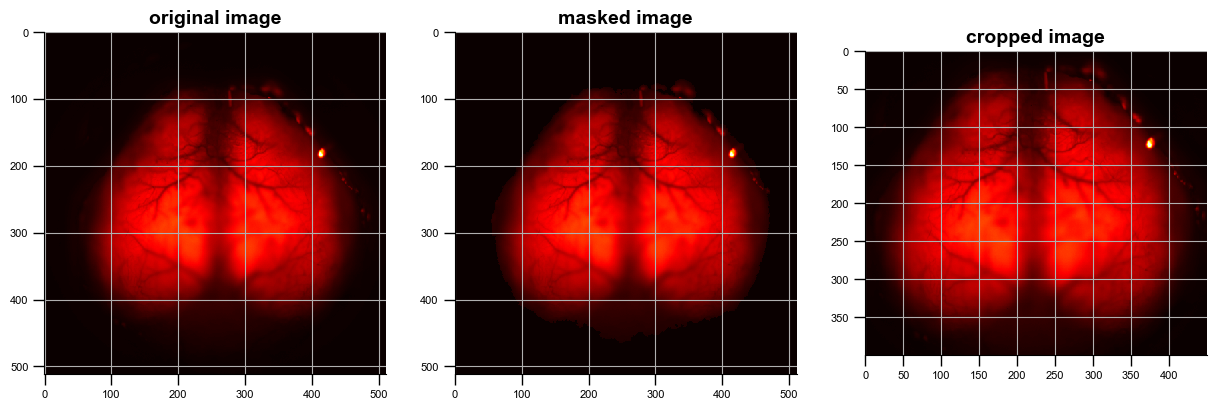

In [58]:
angle = 0 # if clockwise, use negative angle, otherwise positive
left, top, width, height = 40, 60, 450, 400

# use this to check wheather the images need rotation and the suitable angle,
# and the coordinates of ROI to crop the raw images

# select the first tif image of 470nm channel of the first experiment as the reference image
image_ref = imread(glob(pjoin(path_all[0], 'raw/*-470/1.tif'))[0])

cropped_image = rotate_crop_array(image_ref, angle=angle, left=left, top=top, width=width, height=height)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_ref, cmap='hot', aspect='equal')
axs[0].set_title('original image')
axs[0].grid()
axs[1].imshow(image_ref*mask, cmap='hot', aspect='equal')
axs[1].set_title('masked image')
axs[1].grid()
axs[2].imshow(cropped_image, cmap='hot', aspect='equal')
axs[2].set_title('cropped image')
axs[2].grid()
plt.show()

In [61]:
if 'params' not in locals():
    crop = np.array((left, top, width, height))
    # mean intensity of each frame, the fist is 470 channel, the second is 405 channel in the 2nd axis
    params = {'crop': crop, # left, top, width, height
        'mask': mask,
        'n_preview': n_preview,
        'rotate_angle': angle,
        'std_level': std_level}

    result_path = pjoin(path_0, 'results.hdf5')
    h5py_write(result_path, {'params': params})

Path: /home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy
experiment: 20240829-163749


Cropping the images...


Cropping the images...
saving merged tif of 20240829-163749


/home/wrx/.conda/envs/wfield/lib/python3.11/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20240829-163749-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


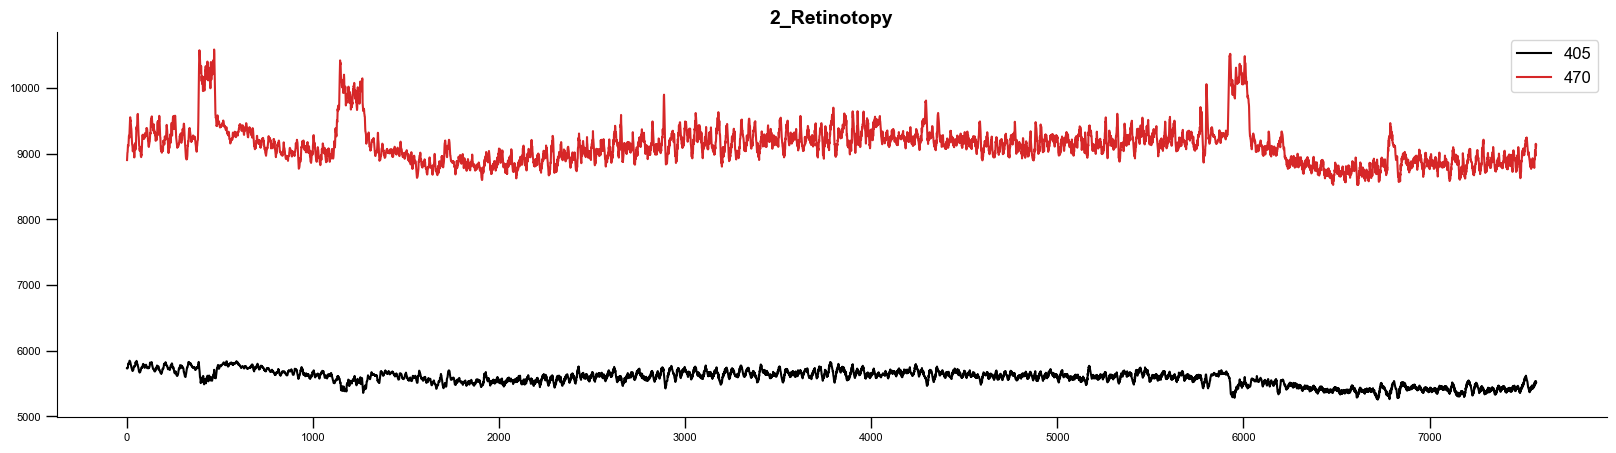

In [62]:
### generate 2-channel tif stack

for path in [path_all[1]]:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    stim_name = path.split('/')[-1]
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiment = list(set([os.path.basename(item)[:15] for item in items]))[0]
    print("experiment:", experiment)

    os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
    mergePath = pjoin(processPath, experiment+"-wfield")
    merge_file = pjoin(mergePath, experiment+"-merged.tif")
    
    tif_405 = image2stack(pjoin(rawPath, experiment + "-405"))
    tif_405 = tif_405*mask
    tif_405 = rotate_crop_array(tif_405, angle=angle, left=left, top=top, width=width, height=height)
    tif_470 = image2stack(pjoin(rawPath, experiment + "-470"))
    tif_470 = tif_470*mask
    tif_470 = rotate_crop_array(tif_470, angle=angle, left=left, top=top, width=width, height=height)

    # check if the number of frames of 405 and 470 are the same
    if tif_405.shape[0] != tif_470.shape[0]:
        n_frames = min(tif_405.shape[0], tif_470.shape[0])
        tif_405 = tif_405[:n_frames]
        tif_470 = tif_470[:n_frames]
    # merge 470 and 405 channel, the first channel is 470, the second channel is 405
    merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
    print("saving merged tif of "+ experiment)
    imwrite(merge_file, merged_tif.astype(np.uint16), imagej=True, bigtiff=True)

    mean_tif = np.mean(merged_tif, axis=(2, 3))
    if plot_test:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_tif[:, 1], label='405')
        ax.plot(mean_tif[:, 0], label='470')
        ax.legend()
        plt.title(stim_name)
        plt.show()

    values_405_path = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
    values_470_path = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
    np.savetxt(values_405_path, mean_tif[:, 1], delimiter=',')
    np.savetxt(values_470_path, mean_tif[:, 0], delimiter=',')


In [ ]:
# images to movie for hehavioral data
path = path_all[1]
rawPath = pjoin(path, "raw")
processPath = pjoin(path, "process")
items = glob(pjoin(rawPath, '202?????-??????-4*'))
experiment = list(set([os.path.basename(item)[:15] for item in items]))
print("experiments:", experiment)
mergePath = pjoin(processPath, experiment[0]+"-wfield")
event_file = pjoin(mergePath, experiment[0]+"-event.tif")
print("event file:", event_file)
if not os.path.exists(event_file):
    tif_event = organize_tif(pjoin(rawPath, experiment[0] + "-event"))
    # imwrite(event_file, tif_event)

### Onset and offset detection

In [ ]:
# to generate the trials.csv and trial_onsets.npy for the wfield software

n_movie_rep = 5
frame_rate = 10 # Hz

for path_wfield in [path_wfield_all[0]]:
    stim_name = path_wfield.split('/')[-3]
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    
    even_data = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
    n_tif = len(os.listdir(glob(pjoin(rawPath, '*-470'))[0]))
    event_frame_rate = np.round(len(even_data) / n_tif).astype(int)
    onset_frame_index = np.round((np.where(np.diff(even_data[:, 0]) == 1)[0] + 1) / event_frame_rate).astype(int)
    offset_frame_index = np.round((np.where(np.diff(even_data[:, 0]) == -1)[0] + 1) / event_frame_rate).astype(int)

    # Interval between two onsets less than 1s may be false onset
    false_onset = np.where(np.diff(onset_frame_index) < 10)[0] + 1
    onset_frame_index = np.delete(onset_frame_index, false_onset) # delete the false onset
    offset_frame_index = np.delete(offset_frame_index, false_onset)

    if 'SalienceGrating' in stim_name or 'SalienceMovingGrating' in stim_name:
        # For those two stimulus, the first onset of the stimlus in this list should ignore,
        # because the first onset without stimuli, just the start of the experiment
        onset_frame_index = onset_frame_index[1:]
        offset_frame_index = offset_frame_index[1:]

    if 'Spontaneous' not in stim_name: # for Spontaneous, there is no onset and offset events
        # if the minimum interval between two onsets is less than 10 frames, raise an error
        if np.diff(onset_frame_index).min() < 10: 
            raise ValueError("The minimum interval between two onsets is less than 1s, please check the stim-file)")

        plot_onset_index(onset_frame_index, title=stim_name) # to check the onset of the trials
        trials_csv = np.stack((np.arange(len(onset_frame_index)),
                            onset_frame_index, 
                            offset_frame_index, 
                            offset_frame_index-onset_frame_index), axis=1)
        np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
        print("generate trials.csv of "+experiment)
    
    # if 'Retinotopy' in path_wfield:
    #     trial_onsets = np.stack((np.arange(len(onset_frame_index)), onset_frame_index-30, offset_frame_index), axis=1)  # 这个文件给wfield软件做SVD用
    #     # np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
    
    # elif 'natural-movie' in path_wfield:
    #     n_movie = len(onset_frame_index)//n_movie_rep
    #     trial_onsets = np.empty((n_movie,3))
    #     for i in range(n_movie):
    #         trial_onsets[i] = [i, onset_frame_index[i*n_movie_rep]-100, offset_frame_index[i*n_movie_rep]]
        # np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
    # elif 'speed' in path_wfield:
    #     trial_onsets = [0, onset_frame_index[0] - 100, offset_frame_index[0]]
    #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用

print("\nAll generation of trials-file finished!")

In [ ]:
if 'trials_csv' not in locals():
    trials_csv = np.loadtxt(pjoin(path_wfield, 'trials.csv'), delimiter=',')
# if 'trial_onsets' not in locals():
#     trial_onsets = np.load(pjoin(path_wfield, 'trial_onsets.npy'))

### Calculate the velocity of the encoder

In [ ]:
def cal_velocity(even_data, step=100, window=1000):
    '''
    Calculate the speed of a motor encoder based on wave_A and wave_B channels
    When the codewheel rotates in the clockwise direction (as viewed from the 
    encoder end of the motor), channel A will lead channel B. If the codewheel 
    rotates in the counterclockwise direction, channel B will lead channel A.
    step: the step to measure the speed, default is 100
    window: the window size to calculate the speed, default is 1000

    '''

    cpr = 200
    diammeter = 2.54 # cm
    split_index = np.arange(0, even_data.shape[0], step)
    # split_index = np.append(split_index, even_data.shape[0])

    velocity = np.zeros((split_index.size-1))
    for i in range(split_index.size-1):
        wave_A = even_data[split_index[i]:split_index[i]+window, 1]
        wave_B = even_data[split_index[i]:split_index[i]+window, 2]
        raise_A = np.where(np.diff(wave_A) == 1)[0]
        count = 0
        for j in range(raise_A.size):
            if wave_B[raise_A[j]] == 0:
                count += 1
            else:
                count -= 1
        velocity[i] = (count / cpr * np.pi * diammeter)
        
    return velocity

In [ ]:
step = 100
velocity_ls = []
window = 1000

for path_wfield in [path_wfield_all[0]]:
    stim_name = path_wfield.split('/')[-3]
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,"../..", "raw")
    even_data = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
    n_tif = len(os.listdir(glob(pjoin(rawPath, '*-470'))[0]))
    event_frame_rate = np.round(len(even_data) / n_tif).astype(int)

    # Calculate the velocity of the encoder, only for event_frame_rate=100
    if event_frame_rate == 100:
        velocity = cal_velocity(even_data, step=100, window=1000)
        velocity_ls.append(velocity)
    
    # Save the velocity of the encoder to the results.hdf5
    abbrev = [abbrev_dict[key] for key in abbrev_dict.keys() if key in stim_name][0]
    results_path = pjoin(path_0, 'results.hdf5')
    h5py_write(results_path, {abbrev: {'step': step, 'velocity': velocity, 'window': window}})

    if plot_test:
        fig, ax = plt.subplots(figsize=(20, 3))
        x = np.arange(0, len(velocity), step*0.01)
        print(x.shape, len(velocity))
        ax.plot(x, velocity)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Speed (cm/s)')
        plt.title('Speed of the locomotion')
        plt.show()


### Create binary file

In [63]:
# Note: only one tif in the folder, and should no .bin file in the folder before running this cell
for path in [path_wfield_all[1]]:
    print(path)
    _ls = os.listdir(path_wfield_all[1])
    if np.array([_.endswith('.bin') for _ in _ls]).any():
        raise Warning('There are .bin files in the folder, please delete them before running this cell!')
    if np.array([_.endswith('.tif') for _ in _ls]).sum() > 1:
        raise Warning('There are more than one tif files in the folder, please check the folder!')

    tif_stack = TiffStack(path, nchannels=2) # set nchannels=1 for our 2 channel tif file
    print('The frames of the stack:', tif_stack.shape[0])
    if tif_stack.shape[0] == 0:
        raise ValueError('The shape of the stack may be wrong!')
    tif_stack.export_binary(foldername=path, basename='{}'.format(tif_stack.shape[0]))

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 184.30it/s]


The frames of the stack: 7574


Exporting binary:   0%|          | 0/15 [00:00<?, ?it/s]

Exporting binary: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


### Check and correct outliers
There are two types of outliers:
1. luminance: the LED not normaly lighted, the mean value is lower than normal. Using the detect_lum_outliers and correct_lum_outliers functions to detect and correct the outliers.
2. cross-channel: the 405 or 470 channel frames wrongly writed. Using the detect_cross_channel_outliers and correct_cross_channel_outliers functions to detect and correct the outliers.

In [65]:
from analysis_utils import correct_lum_outlier, correct_cross_outlier
from analysis_utils import detect_cross_outlier, detect_lum_outlier

Path: /home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy
experiment: 20240829-163749


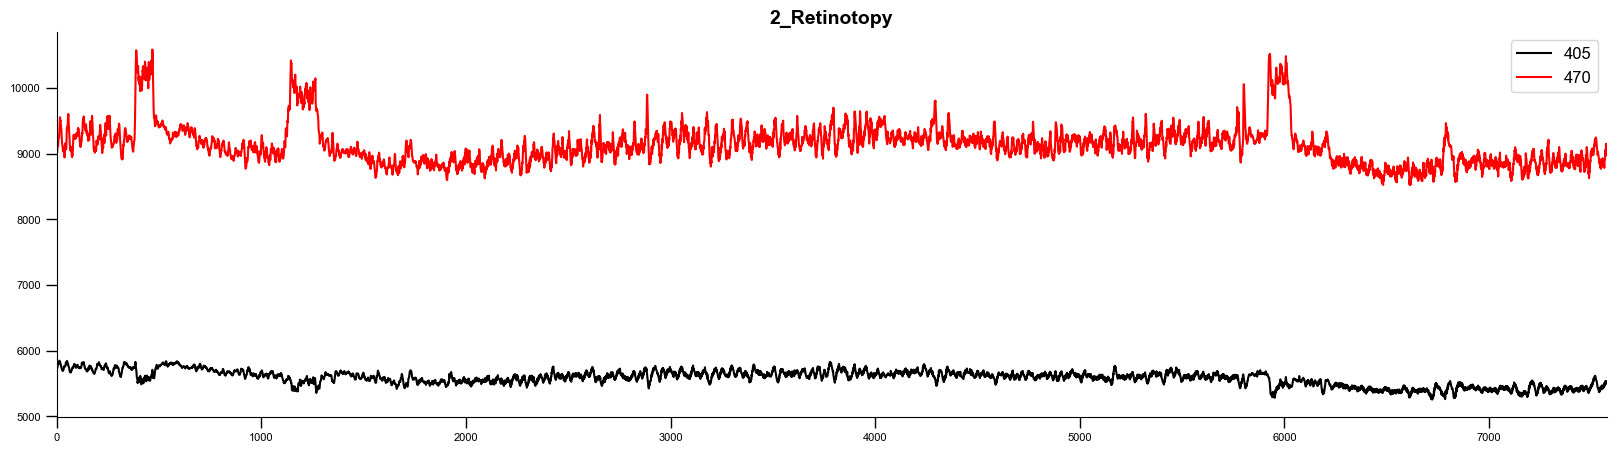

detect_lum_outlier: No dim outliers frames detected!


In [66]:
# detect outliers based on the mean values of 405 and 470 channels,
# and correct the outliers by averaging the values of the previous and next frames

for path in [path_all[1]]:
    stim_name = os.path.split(path)[-1]
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiment = list(set([os.path.basename(item)[:15] for item in items]))[0]
    print("experiment:", experiment)
    
    values_405_path = pjoin(path, "process", '{}-405-Values.csv'.format(experiment))
    values_470_path = pjoin(path, "process", '{}-470-Values.csv'.format(experiment))
    # read data from csv file as numpy array
    mean_values_405 = np.loadtxt(values_405_path, delimiter=',')
    mean_values_470 = np.loadtxt(values_470_path, delimiter=',')
    n_frames = min(mean_values_405.shape[0], mean_values_470.shape[0])
    mean_values_405 = mean_values_405[:n_frames]
    mean_values_470 = mean_values_470[:n_frames]
    
    if plot_test:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_405, label='405', color='k')
        ax.plot(mean_values_470, label='470', color='r')
        ax.set_xlim(0, len(mean_values_405))
        # ax.set_xlim(12200, 12230)
        # ax.set_ylim(2000, 4000)
        # print(outlier_index[1])
        # for idx in outlier_index[1]:
        #     ax.axvline(x=idx, color='r', linestyle='--')
        ax.legend()
        plt.title(stim_name)
        plt.show()

    mean_values = np.concatenate((np.expand_dims(mean_values_470, axis=1), np.expand_dims(mean_values_405, axis=1)), axis=1)
    outlier_index_470, outlier_index_405 = detect_lum_outlier(mean_values, lum_thr_coef=0.3, plot=False)

    if len(outlier_index_470) > 0 or len(outlier_index_405) > 0:
        print("Outliers detected!")
        bin_path = glob(pjoin(processPath, experiment+"-wfield", '*uint16.bin'))[0]
        correct_lum_outlier(bin_path, outlier_index_470, outlier_index_405, plot=False, overwrite=True)

The length difference between 405 and 470 timestamps:  -1
/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield/7574_2_400_450_uint16.bin
No outliers detected!
The mean values of 405 and 470 channels after correction:


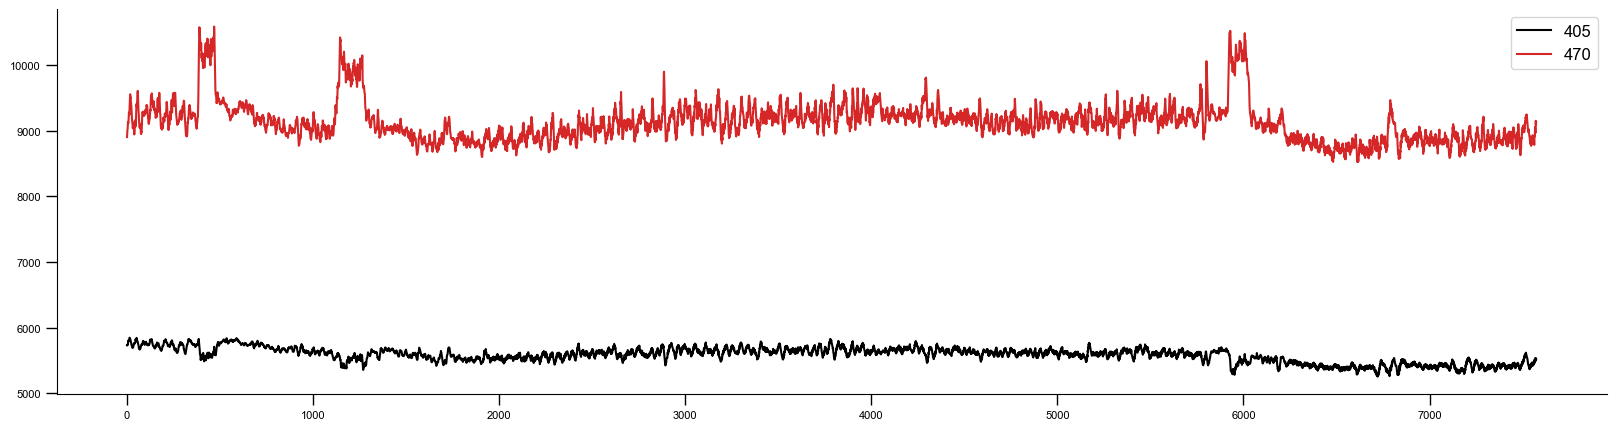

In [ ]:
time_stamp_405 = np.loadtxt(glob(pjoin(path, "raw", '*-405Timestamp.csv'))[0], delimiter=',')
time_stamp_470 = np.loadtxt(glob(pjoin(path, "raw", '*-470Timestamp.csv'))[0], delimiter=',')

if not len(time_stamp_405) == len(time_stamp_470):
    print("The length difference between 405 and 470 timestamps: ", len(time_stamp_405) - len(time_stamp_470))
    _len = min(len(time_stamp_405), len(time_stamp_470))
    time_stamp_405 = time_stamp_405[:_len]
    time_stamp_470 = time_stamp_470[:_len]

outlier_index = detect_cross_outlier(time_stamp_470, time_stamp_405)
bin_path = glob(pjoin(processPath, experiment+"-wfield", '*uint16.bin'))[0]
print(bin_path)

if outlier_index[0].size == 0 and outlier_index[1].size == 0:
    print('No outliers detected!')
    dat = mmap_dat(bin_path)
else:
    print('Outliers detected!')
    dat = correct_cross_outlier(bin_path, outlier_index_470=outlier_index[0], outlier_index_405=outlier_index[1], overwrite=True)
    
print('The mean values of 405 and 470 channels after correction:')
mean_470 = np.mean(dat[:, 0, :, :], axis=(1, 2))
mean_405 = np.mean(dat[:, 1, :, :], axis=(1, 2))
mean_values_corrected = np.concatenate((mean_470[:, np.newaxis], mean_405[:, np.newaxis]), axis=1)

if plot_test:
    
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(mean_405, label='405')
    ax.plot(mean_470, label='470')
    plt.legend()
    plt.show()


Save the mean frame

Save the mean frame of each channel to the results file.

In [68]:
result_path = pjoin(path_0, 'results.hdf5')
print(result_path)
abbrev = [abbrev_dict[key] for key in abbrev_dict.keys() if key in stim_name][0]
results = {'mean_values': mean_values_corrected}
h5py_write(result_path, {abbrev: results})

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/results.hdf5


### Computes baseline

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield
(7574, 2, 400, 450)


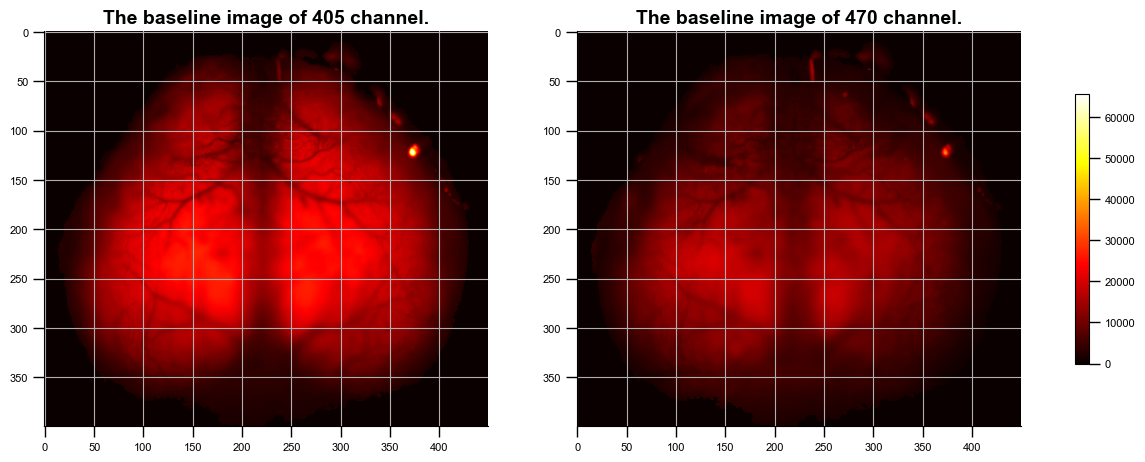

In [72]:
path = path_wfield_all[1]
print(path)
dat = mmap_dat(glob(pjoin(path, '*uint16.bin'))[0])
print(dat.shape)

# the minimum value of the last 300 frames as the baseline image
image_base_min = np.min(dat[-300:, :, :, :], axis=0)
np.save(pjoin(path, 'frames_average.npy'), image_base_min)

if plot_test:
    images = [image_base_min[0], image_base_min[1]]
    title = ['The baseline image of 405 channel.', 'The baseline image of 470 channel.']
    show_images(images, title=title, idential_colorbar=True)
    # fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    # axis[0].imshow(image_base_min[0], cmap='hot', aspect='equal')
    # axis[0].grid()
    # axis[0].set_title('The baseline image of 405 channel')
    # axis[1].imshow(image_base_min[1], cmap='hot', aspect='equal')
    # axis[1].grid()
    # axis[1].set_title('The baseline image of 470 channel')
    # plt.show()

Approximate single value decomposition

Computing SVT from the raw data: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


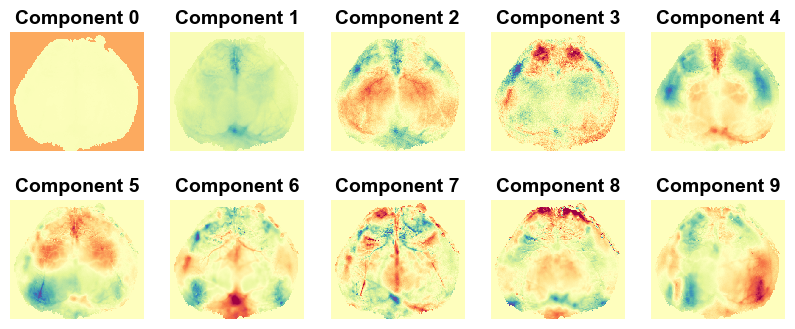

In [73]:
U, SVT = approximate_svd(dat, image_base_min)

np.save(pjoin(path,'U.npy'), U)
np.save(pjoin(path,'SVT.npy'), SVT)

if plot_test:
    ncomponents = 10
    ncols = 5
    nrows = int(np.ceil(ncomponents/ncols))
    fig = plt.figure(figsize=[2*ncols, 2*nrows])
    for icomponent in range(ncomponents):
        fig.add_subplot(nrows, ncols, icomponent+1)
        plt.imshow(U[:, :, icomponent], clim=[-0.01,0.01],cmap='Spectral_r')
        plt.title('Component {}'.format(icomponent))
        plt.axis('off')
    plt.show()

Hemodynamic correction

In [74]:
path = path_wfield_all[1]
print(path)
if 'SVT' not in locals():
    print('loading SVT.npy...')
    SVT = np.load(pjoin(path, 'SVT.npy'))
if 'U' not in locals():
    print('loading U.npy...')
    U = np.load(pjoin(path, 'U.npy'))

tstart = time.time()
fs = 10
freq_highpass = 0.001
SVT_470 = SVT[:,0::2]
t = np.arange(SVT.shape[1]) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2], SVT[:,1::2], axis=1,
                    fill_value='extrapolate')(t[0::2])
# SVTcorr, rcoeffs, T = hemodynamic_correction(U, 
#                                              SVT_470, 
#                                              SVT_405, 
#                                              fs=fs,
#                                              freq_highpass=freq_highpass,
#                                              freq_lowpass=10)  

print('Done hemodynamic correction in {0} s '.format(time.time()-tstart))
SVTcorr = SVT_470 - SVT_405

# np.save(pjoin(path,'rcoeffs.npy'), rcoeffs)
# np.save(pjoin(path,'T.npy'),T)
np.save(pjoin(path,'SVTcorr.npy'), SVTcorr)

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield
Done hemodynamic correction in 0.027195215225219727 s 


In [ ]:
if 'SVTcorr' not in locals():
    SVTcorr = np.load(pjoin(path, 'SVTcorr.npy'))

PhaseMap

In [ ]:
# using phasemap.ipynb

In [77]:
if 'Retinotopy' in path:
    path_out = pjoin(path, '..', os.path.basename(path)[:16]+'retinotopy')
    os.makedirs(path_out, exist_ok=True) if not os.path.exists(path_out) else None
    print(path_out)

/home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield/../20240829-163749-retinotopy


In [78]:
trials = pd.read_csv(pjoin(path, "trials.csv"), header=None, dtype=int).values

In [85]:
nrepeats = 10
post_trial = 30 # the post trial frames
nframes_el = min(trials[:20, 3]) + post_trial
nframes_az = min(trials[20:40, 3]) + post_trial

In [ ]:
if 'U' not in locals() or 'SVTcorr' not in locals():
    U = np.load(pjoin(path, 'U.npy'))
    SVTcorr = np.load(pjoin(path, 'SVTcorr.npy'))

nSVD = SVTcorr.shape[0]

# extract trial-data for 4 direction stimuli respectively.
def sort_frames(nframes, *ntrials):
    avg = np.empty((nSVD, 0, nframes))
    raw = np.empty((nSVD, 0))
    for i in ntrials:
        avg = np.concatenate((avg, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes].reshape(nSVD, 1, nframes)), axis=1)
        raw = np.concatenate((raw, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes]), axis=1)
    avg = np.mean(avg, axis=1)
    return avg, raw

avg_up, raw_up = sort_frames(nframes_el, *range(nrepeats * 0, nrepeats * 1))
avg_down, raw_down = sort_frames(nframes_el, *range(nrepeats * 1, nrepeats * 2))
avg_left, raw_left = sort_frames(nframes_az, *range(nrepeats * 2, nrepeats * 3))
avg_right, raw_right = sort_frames(nframes_az, *range(nrepeats * 3, nrepeats * 4))

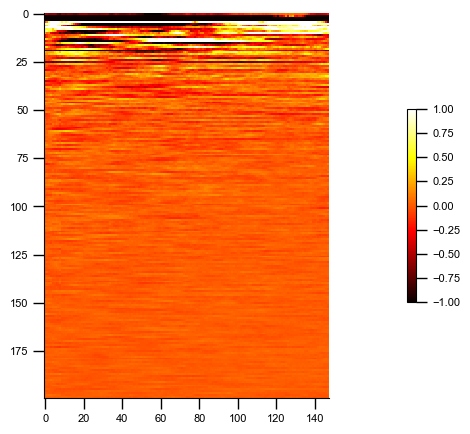

In [ ]:
if plot_test:
    fig, ax = plt.subplots(figsize=(20, 5))
    cb = ax.imshow(avg_up, cmap='Spectral_r', clim=[-1, 1]) # 
    fig.colorbar(cb, ax=ax, orientation='vertical', fraction=0.05, shrink=0.5)
    plt.show()

In [ ]:
# from numpy.fft import fft

# sp = fft(raw_up.T, axis=0)
# freq = np.fft.fftfreq(sp.shape[0])
# plt.plot(freq, sp.real, freq, sp.imag)

# if plot_test:
#     fig, ax = plt.subplots(figsize=(20, 5))
#     cb = ax.imshow(sp, cmap='Spectral_r') # 
#     fig.colorbar(cb, ax=ax, orientation='vertical', fraction=0.05, shrink=0.5)
#     plt.show()

In [115]:
from wfield import im_fftphase_hsv, reconstruct, visual_sign_map

### computes fft in SVD space
component = 10
# from scipy.ndimage import gaussian_filter,median_filter
# mov = runpar(median_filter, U.transpose((2, 0, 1)), size=5)
# U1 = np.stack(mov).transpose((1, 2, 0)).astype(np.float32)
up = reconstruct(U, fft(raw_up.T, axis=0)[component])
down = reconstruct(U, fft(raw_down.T, axis=0)[component])
left = reconstruct(U, fft(raw_left.T, axis=0)[component])
right = reconstruct(U, fft(raw_right.T, axis=0)[component])
phase_el = -1. * (np.angle(up) - np.angle(down))
# phase_el = (phase_el + np.pi) % (2 * np.pi)
phase_el = (phase_el) % (2 * np.pi)
mag_el = (np.abs(up + down) * 2.)

phase_az = -1. * (np.angle(left) - np.angle(right))
# phase_az = (phase_az + np.pi) % (2 * np.pi)
phase_az = (phase_az) % (2 * np.pi)
mag_az = (np.abs(left + right) * 2.)


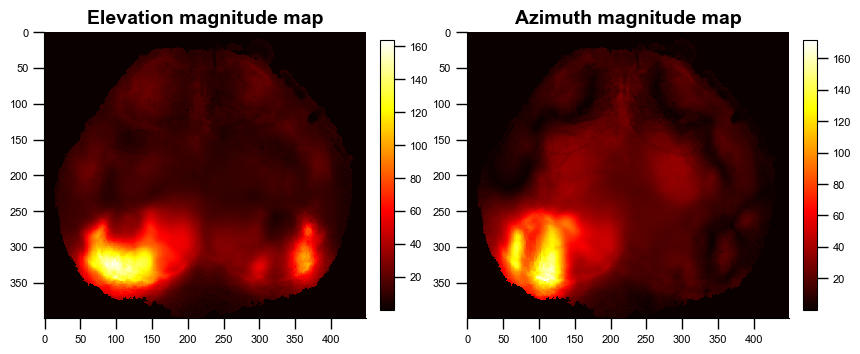

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cb = axs[0].imshow(mag_el, cmap='hot')
fig.colorbar(cb, ax=axs[0], fraction=0.046, pad=0.04, shrink=0.7)
axs[0].set_title('Elevation magnitude map')

cb = axs[1].imshow(mag_az, cmap='hot')
fig.colorbar(cb, ax=axs[1], fraction=0.046, pad=0.04, shrink=0.7)
axs[1].set_title('Azimuth magnitude map')
plt.show()

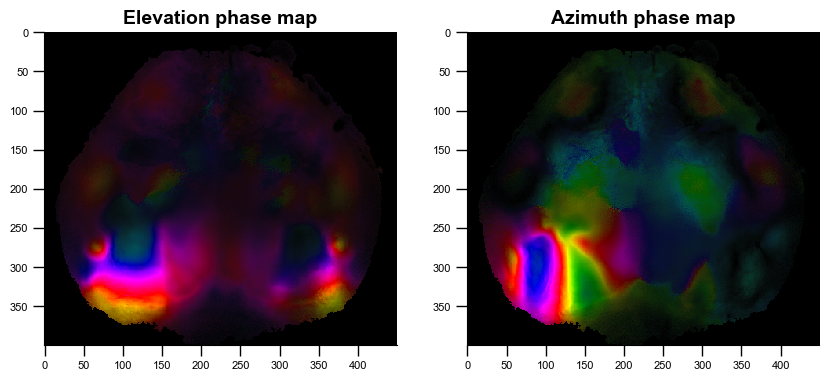

In [117]:
### plot phase maps

# fig = plt.figure(figsize=[10, 5])
fig, axs = plt.subplots(1, 2, figsize=[10, 7])
# fig.add_subplot(1, 2, 1)
cb = axs[0].imshow(im_fftphase_hsv([mag_el, phase_el], return_hsv=False))
# plt.axis('off')
# fig.colorbar(cb, ax=axs[0], location='bottom', shrink=0.8)
axs[0].set_title('Elevation phase map')

axs[1].imshow(im_fftphase_hsv([mag_az, phase_az], return_hsv=False))
# plt.axis('off')
axs[1].set_title('Azimuth phase map')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'el_az_unfiltered.png'))
plt.show()

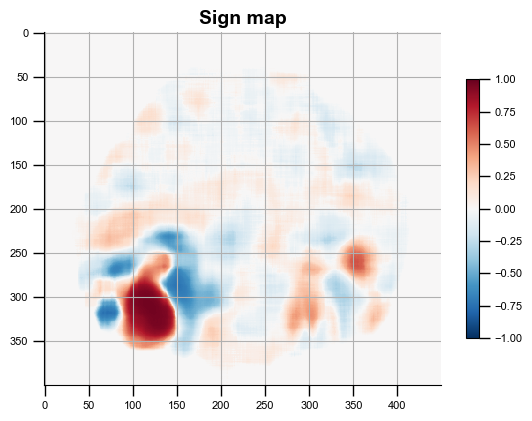

In [119]:
### plot sign maps
from scipy.ndimage import median_filter

sign_map = median_filter(visual_sign_map(phase_az, phase_el), 33)
np.save(pjoin(path_out, 'sign_map.npy'), sign_map)
fig = plt.figure()
plt.imshow(sign_map,
           cmap='RdBu_r', clim=[-1, 1])
plt.grid()
plt.colorbar(shrink=0.7)
x, y = 153, 320
# plt.plot(x, y, 'o', color='black', markersize=5)
# plt.axis('off')
plt.title('Sign map')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'signmap.png'))
plt.show()

Plot HVA

To launch the GUI to explore processed data do: `wfield open <FOLDER>`
`wfield open /home/wrx/Data_WF/WF_WRX/Q39/20240829_saline/2_Retinotopy/process/20240829-163749-wfield`

In [ ]:
# using plot_HVA.ipynb
# using match_dorsal_cortex_to_allen.ipynb to match the dorsal cortex to allen atlas

In [130]:
from wfield import allen_load_reference
from wfield import load_allen_landmarks
from wfield import allen_transform_regions

In [ ]:
lmarks = load_allen_landmarks(pjoin(path, 'dorsal_cortex_landmarks.json'))
# print(lmarks)


{'bregma_offset': [225, 120], 'landmarks':       x     y       name    color
0 -1.95 -3.45    OB_left  #fc9d03
1  0.00 -3.45  OB_center  #0367fc
2  1.95 -3.45   OB_right  #fc9d03
3  0.00  3.20   RSP_base  #fc4103, 'landmarks_im':             x           y       name    color
0  124.484536  -57.835052    OB_left  #fc9d03
1  225.000000  -57.835052  OB_center  #0367fc
2  325.515464  -57.835052   OB_right  #fc9d03
3  225.000000  284.948454   RSP_base  #fc4103, 'landmarks_match':             x           y       name    color
0  169.972071   25.260286    OB_left  #fc9d03
1  226.849545   33.667276  OB_center  #0367fc
2  287.022548   30.217703   OB_right  #fc9d03
3  227.756773  304.611607   RSP_base  #fc4103, 'resolution': 0.0194, 'transform': <SimilarityTransform(matrix=
    [[ 7.60973574e-01, -5.05365591e-03,  5.68219789e+01],
     [ 5.05365591e-03,  7.60973574e-01,  7.61007940e+01],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]) at 0x7feea0e6c550>, 'transform_type': 'euclidian'}

In [128]:

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')

In [131]:
ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

In [133]:
cropped_image.shape

(400, 450)

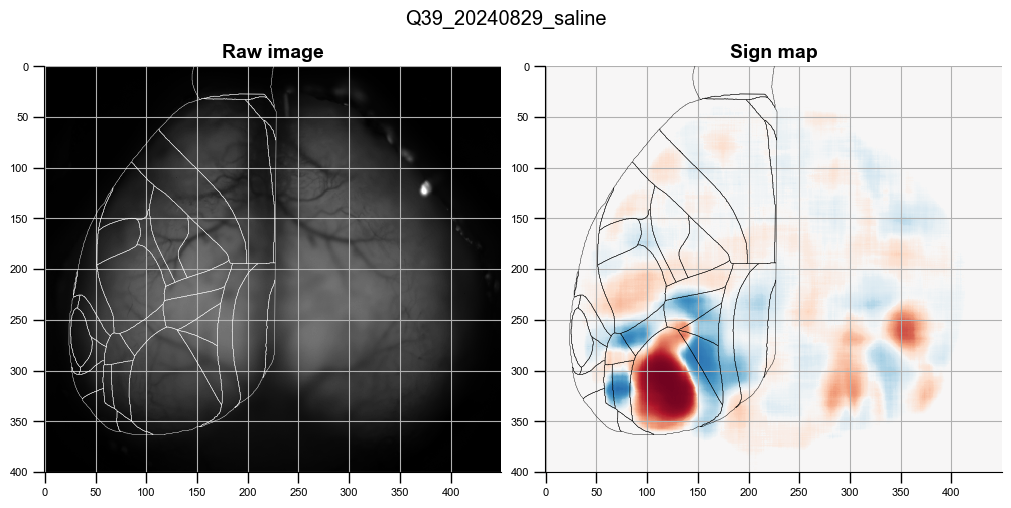

In [149]:

nrows = 1
ncols = 2

fig, axis = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), layout='constrained')

axis[0].imshow(cropped_image, cmap='grey')
axis[0].grid()
axis[0].set_ylim([cropped_image.shape[0], 0])
axis[0].set_title('Raw image')

axis[1].imshow(sign_map, cmap='RdBu_r', clim=[-1, 1])
axis[1].grid()
axis[1].set_ylim([sign_map.shape[0], 0])
axis[1].set_title('Sign map')

# plot the regions overlayed on the sign map
for i,r in ccf_regions_im.iterrows():
    axis[0].plot(r['left_x'],r['left_y'], 'white', lw=0.3)
    axis[1].plot(r['left_x'],r['left_y'], 'k', lw=0.3)

title = '{}_{}'.format(mice_id, treat)
plt.suptitle(title)
plt.show()

Extract Trace

In [ ]:
atlas, areanames, brain_mask = atlas_from_landmarks_file(pjoin(localdisk, 'dorsal_cortex_landmarks.json'))
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(localdisk, 'dorsal_cortex_landmarks.json'), do_transform = True) # this loads the untransformed atlas

NameError: name 'atlas_from_landmarks_file' is not defined

# Others 

for testing

In [ ]:
# compare the correct method
correct_compare = np.concatenate((corr_470_405, _d), axis=2)
display_wrapper(correct_compare, figsize=(15, 7.5))
# save the correct_compare as tiff file
# tif_path = pjoin(path_wfield_all[0], 'correct_compare.tif')
# print('saving correct_compare tif file:', tif_path)
# imwrite(tif_path, correct_compare.astype(np.float32))

In [ ]:
# for path_wfield in [path_wfield_all[0]]:
#     if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
#         print(path_wfield,"can't find merged tiff file！\n")
#     elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
#         print(path_wfield,"exist multiple merged tiff file！\n")
#     elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
#         print(path_wfield,'analysis has been finished！\n')
#     else:
#         print('Start analyze',path_wfield)
#         if 'natural-movie' or 'speed' in path_wfield:
#             nbaseline_frames = 100
#         else:
#             nbaseline_frames = 30
#         command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
#         logfile = pjoin(path_wfield, 'log.txt')
#         with open(logfile, "w") as log:
#             result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
#             log.write(result.stdout)
#         if result.returncode == 0:
#             print('Finish analyzing',path_wfield,'\n')
#         else:
#             print('！！！Error occured when analyzing',path_wfield,'\n')
        
# print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')

In [ ]:
# compare the spontaneous activity of selected frames before and after the stimulus

# if 'Spontaneous' in stim_name:

#     dat_pre = dat[:3000, 0, :, :]
#     dat_post = dat[-3000:, 0, :, :]
#     print(dat_pre.shape, dat_post.shape)
#     dat_pre_std = np.std(dat_pre, axis=0)
#     print(dat_pre_std.shape)
#     dat_post_std = np.std(dat_post, axis=0)
#     print(dat_post_std.shape)
#     dat_post1 = dat[3000:6000, 0, :, :]
#     dat_post2 = dat[6000:9000, 0, :, :]
#     dat_post1_std = np.std(dat_post1, axis=0)
#     dat_post2_std = np.std(dat_post2, axis=0)

#     dat_post1 = dat[3000:6000, 0, :, :]
#     dat_post2 = dat[6000:9000, 0, :, :]
#     dat_post1_std = np.std(dat_post1, axis=0)
#     dat_post2_std = np.std(dat_post2, axis=0)

#     fig, axs = plt.subplots(2, 2, figsize=(15, 10))
#     # vmin = min(dat_pre_std.min(), dat_post_std.min(), dat_post1_std.min(), dat_post2_std.min())
#     # vmax = max(dat_pre_std.max(), dat_post_std.max(), dat_post1_std.max(), dat_post2_std.max())

#     vmin = min(dat_pre_std.min(), dat_post_std.min(), dat_post2_std.min())
#     vmax = max(dat_pre_std.max(), dat_post_std.max(), dat_post2_std.max())

#     cb = axs[0, 0].imshow(dat_pre_std, cmap='hot', vmin=vmin, vmax=vmax)
#     axs[0, 0].set_title('std of pre (0-3000)')
#     axs[0, 0].grid()
#     fig.colorbar(cb, ax=axs[0, 0], shrink=0.5)

#     cb = axs[0, 1].imshow(dat_post1_std, cmap='hot', vmin=vmin, vmax=vmax)
#     axs[0, 1].set_title('std of 3000-6000')
#     axs[0, 1].grid()
#     fig.colorbar(cb, ax=axs[0, 1], shrink=0.5)

#     cb = axs[1, 0].imshow(dat_post2_std, cmap='hot', vmin=vmin, vmax=vmax)
#     axs[1, 0].set_title('std of 6000-9000')
#     axs[1, 0].grid()
#     fig.colorbar(cb, ax=axs[1, 0], shrink=0.5)

#     cb = axs[1, 1].imshow(dat_post_std, cmap='hot', vmin=vmin, vmax=vmax)
#     axs[1, 1].set_title('std of post (-3000:)')
#     axs[1, 1].grid()
#     fig.colorbar(cb, ax=axs[1, 1], shrink=0.5)
#     plt.show()

In [ ]:
# start_idx = 0
# end_idx = 500
# delt_470 = (dat[start_idx:end_idx, 0, :, :] - baseline_frame[0]) / baseline_frame[0]
# display_wrapper(delt_470, cmap='gray', figsize=(5, 5))

# delt_405 = (dat[start_idx:end_idx, 1, :, :] - baseline_frame[1]) / baseline_frame[1]
# display_wrapper(delt_405, cmap='gray', figsize=(5, 5))

# corr_470_405 = delt_470 - delt_405
# display_wrapper(corr_470_405, cmap='gray', figsize=(7.5, 7.5))

# coffers = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]))
# combines = np.zeros((frames_average_trials.shape[0], frames_average_trials.shape[2], frames_average_trials.shape[3]*3))
# for i in range(frames_average_trials.shape[0]):
#     cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
#     coffers[i] = cof

#     standardized_470 = standardization(frames_average_trials[i, 0, :, :])
#     standardized_405 = standardization(frames_average_trials[i, 1, :, :])
#     standardized_cof = standardization(cof)
#     normalized_470 = normalization(frames_average_trials[i, 0, :, :])
#     normalized_405 = normalization(frames_average_trials[i, 1, :, :])
#     normalized_cof = normalization(cof)
#     # combines[i] = np.concatenate((standardized_470, standardized_405, standardized_cof), axis=1)
#     combines[i] = np.concatenate((normalized_470, normalized_405, normalized_cof), axis=1)

# # cof = np.divide(frames_average_trials[i, 0, :, :], frames_average_trials[i, 1, :, :])
# # plt.imshow(cof, cmap='jet')
# # plt.colorbar()
# # plt.show()

In [ ]:
from wfield_utils import reconstruct
mov = reconstruct(U,SVT).reshape(SVT.shape[1], *U.shape[:2])
print(mov.shape)